In [2]:
from google.colab import drive
drive.mount('/content/drive/')

import os

# Path to your Google Drive folder
drive_folder = '/content/drive/My Drive/Expt5_images/'

# List contents of the folder
folder_contents = os.listdir(drive_folder)
print(folder_contents)


Mounted at /content/drive/
['22869_img2.ppm', '22863_flow.flo', '22868_img2.ppm', '22865_img2.ppm', '22862_flow.flo', '22868_img1.ppm', '22865_img1.ppm', '22864_img1.ppm', '22867_flow.flo', '22869_img1.ppm', '22862_img1.ppm', '22866_img1.ppm', '22866_flow.flo', '22871_flow.flo', '22869_flow.flo', '22867_img1.ppm', '22870_img1.ppm', '22871_img2.ppm', '22863_img2.ppm', '22871_img1.ppm', '22863_img1.ppm', '22868_flow.flo', '22864_flow.flo', '22864_img2.ppm', '22870_img2.ppm', '22867_img2.ppm', '22862_img2.ppm', '22866_img2.ppm', '22865_flow.flo', '22870_flow.flo', '22869_img2.png', '22869_img1.png']


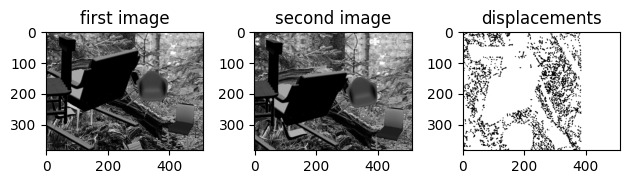

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


'''
    inRange checks whether the given cordinates line in the given image limits
 cordinates, limits are tuples i.e., (X,Y)
'''
def inRange( cordinates, limits):
	x,y = cordinates
	X_Limit, Y_Limit = limits
	return 0 <= x and x < X_Limit and 0 <= y and y < Y_Limit

'''
    opticalFlow calculates the displacements in X and Y directions i.e., (u,v)
    given two consecutive images varying with time
'''
def optical_flow(old_frame, new_frame, window_size, min_quality=0.01):

    max_corners = 10000
    min_distance = 0.1
    feature_list = cv2.goodFeaturesToTrack(old_frame, max_corners, min_quality, min_distance)

    w = int(window_size/2)

    old_frame = old_frame / 255
    new_frame = new_frame / 255

    #Convolve to get gradients w.r.to X, Y and T dimensions
    kernel_x = np.array([[-1, 1], [-1, 1]])
    kernel_y = np.array([[-1, -1], [1, 1]])
    kernel_t = np.array([[1, 1], [1, 1]])

    fx = cv2.filter2D(old_frame, -1, kernel_x)              #Gradient over X
    fy = cv2.filter2D(old_frame, -1, kernel_y)              #Gradient over Y
    ft = cv2.filter2D(new_frame, -1, kernel_t) - cv2.filter2D(old_frame, -1, kernel_t)  #Gradient over Time


    u = np.zeros(old_frame.shape)
    v = np.zeros(old_frame.shape)

    for feature in feature_list:        #   for every corner
            j, i = feature.ravel()		#   get cordinates of the corners (i,j). They are stored in the order j, i
            i, j = int(i), int(j)		#   i,j are floats initially

            I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            b = np.reshape(I_t, (I_t.shape[0],1))
            A = np.vstack((I_x, I_y)).T

            U = np.matmul(np.linalg.pinv(A), b)     # Solving for (u,v) i.e., U

            u[i,j] = U[0][0]
            v[i,j] = U[1][0]

    return (u,v)


'''
Draw the displacement vectors on the image, given (u,v) and save it to the output filepath provided
'''
def drawOnFrame(frame, U, V, output_file):

    line_color = (0, 255, 0) #  Green

    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            u, v = U[i][j], V[i][j]

            if u and v:
                frame = cv2.arrowedLine( frame, (i, j), (int(round(i+u)), int(round(j+v))),
                                        (0, 255, 0),
                                        thickness=1
                                    )
    cv2.imwrite(output_file, frame)


'''
Create a plot of the displacement vectors given (u,v) and plot the two images and displacement in a row.
Save the plot to given output filepath
'''
def drawSeperately(old_frame, new_frame, U, V, output_file):

    displacement = np.ones_like(img2)
    displacement.fill(255.)             #Fill the displacement plot with White background
    line_color =  (0, 0, 0)
    # draw the displacement vectors
    for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):

            start_pixel = (i,j)
            end_pixel = ( int(i+U[i][j]), int(j+V[i][j]) )

            #check if there is displacement for the corner and endpoint is in range
            if U[i][j] and V[i][j] and inRange( end_pixel, img1.shape ):
                displacement = cv2.arrowedLine( displacement, start_pixel, end_pixel, line_color, thickness =2)

    figure, axes = plt.subplots(1,3)
    axes[0].imshow(old_frame, cmap = "gray")
    axes[0].set_title("first image")
    axes[1].imshow(new_frame, cmap = "gray")
    axes[1].set_title("second image")
    axes[2].imshow(displacement, cmap = "gray")
    axes[2].set_title("displacements")
    figure.tight_layout()
    plt.savefig(output_file, bbox_inches = "tight", dpi = 200)



#   Read Input
image_path1 = "/content/22871_img1.png"
image_path2 = "/content/22871_img2.png"
#print(os.path.exists(image_path1))
img1 = cv2.imread(image_path1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread(image_path2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Obtain (u,v) from Lucas Kanade's optical flow approach
U, V = optical_flow( img1, img2, 3, 0.05)

output_directory = "./content/drive/MyDrive/Expt5/Results/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save results
img2 = cv2.cvtColor( img2, cv2.COLOR_GRAY2RGB)
drawSeperately(img1, img2, U, V, "./content/drive/MyDrive/Expt5/Results/Grove_Seperate_Result.png")
drawOnFrame(img2, U, V, './content/drive/MyDrive/Expt5/Results/Grove_Result.png')

flow = np.sqrt(U**2 + V**2)
np.save('flow.npy',flow)